In [494]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

In [495]:
df = pd.read_csv('/kaggle/input/data-science-day1-titanic/DSB_Day1_Titanic_train.csv')

In [496]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Заполнение пропусков и создание нового признака Has_Cabin

In [497]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [498]:
# Заполнение пропусков в 'Age' медианой
df['Age'].fillna(df['Age'].median(), inplace=True)

# Создание нового признака 'Has_Cabin'
df['Has_Cabin'] = df['Cabin'].notnull().astype(int)

# Удаление колонки 'Cabin', так как она имеет слишком много пропусков
df.drop(columns=['Cabin'], inplace=True)

# Заполнение пропусков в 'Embarked' модой
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

/tmp/ipykernel_30/2490620713.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipykernel_30/2490620713.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [499]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Has_Cabin      0
dtype: int64

## Анализ данных, для создания новых признаков

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


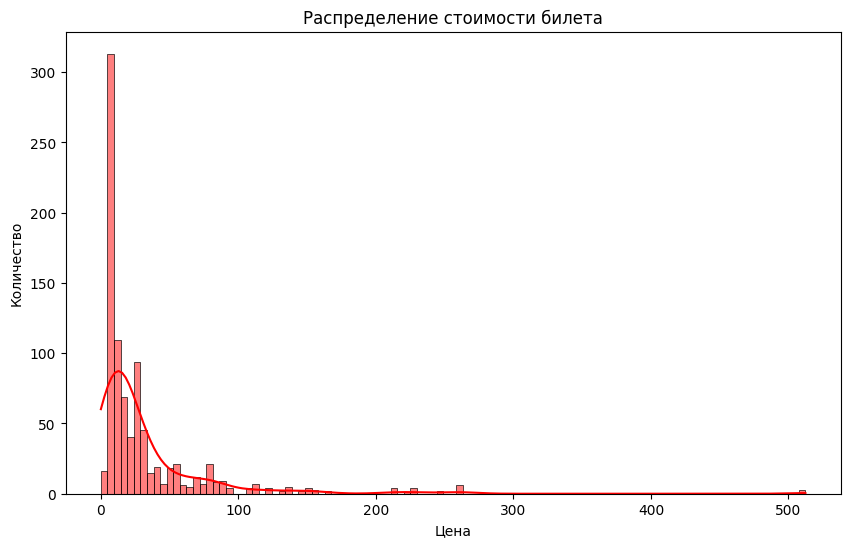

In [500]:
plt.figure(figsize=(10, 6))

sns.histplot(df['Fare'], kde=True, color='red')

plt.title('Распределение стоимости билета')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

Из этого графика можно увидить, что распределение цены билетов было очень неравномерное, больше всего есть билетов с ценой от 0 до 25, меньше от 25 до 50, еще меньше от 50 до 100 и совсем малое количество очень дорогих билетов с ценой от 100.

Можно сделать распределние по категориям цены билета и посмотреть зависимость выживаемости от категории билета

/tmp/ipykernel_30/4131830696.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival_rate = df.groupby(fare_category)['Survived'].mean().reset_index()
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


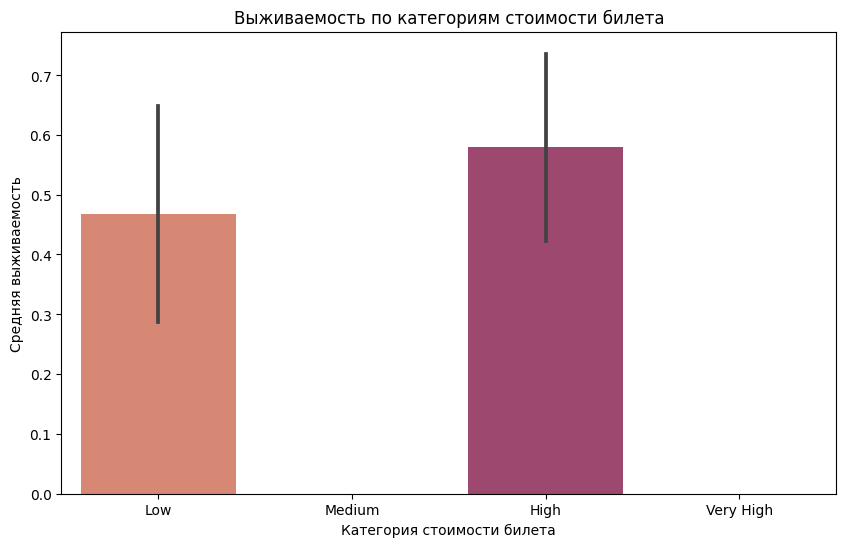

In [501]:
# Преобразуем цену билета в категориальный признак
bins = [0, 25, 50, 100, float('inf')]  # Определяем интервалы
labels = [0, 1, 2, 3]  # Метки для категорий
fare_category = pd.cut(df['Fare'], bins=bins, labels=labels, right=False)

# Группировка по категориям стоимости билета и выживаемости
fare_survival_rate = df.groupby(fare_category)['Survived'].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x=fare_category, 
    y='Survived', 
    data=fare_survival_rate, 
    palette="flare"
)
plt.title('Выживаемость по категориям стоимости билета')
plt.xlabel('Категория стоимости билета')
plt.ylabel('Средняя выживаемость')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Low', 'Medium', 'High', 'Very High'])
plt.show()

Судя по графику можно сказать, что с повышением цены возрастает и шанс выжить, так люди с самой низкой стоимостью билета имеют самые низкие шансы выжить, а люди с дорогими билетами выживали в >60% случаях

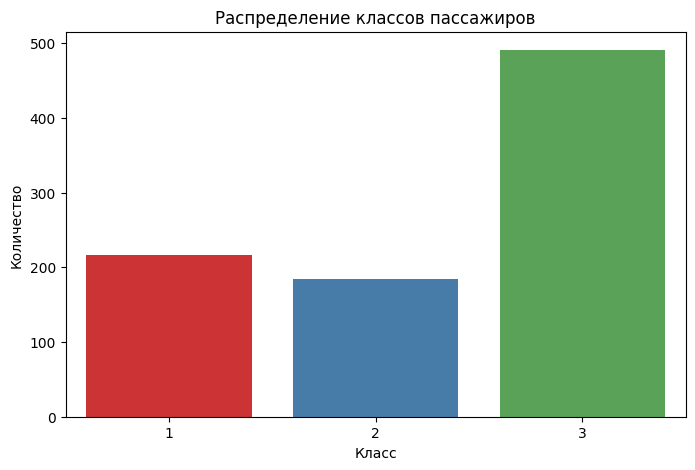

In [502]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x=df['Pclass'].value_counts().index, 
    y=df['Pclass'].value_counts().values, 
    palette="Set1"
)

plt.title('Распределение классов пассажиров')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

Исходя из графика видно, что есть всего три класса пассажиров, причем больше всего пассажиров 3 класса, меньше пассажиров 1 класса и наименьшее количество людей являются пассажирами 2 класса

Исходя из этого графика можно посмотреть как влияет класс пассажира на его выживаемость 

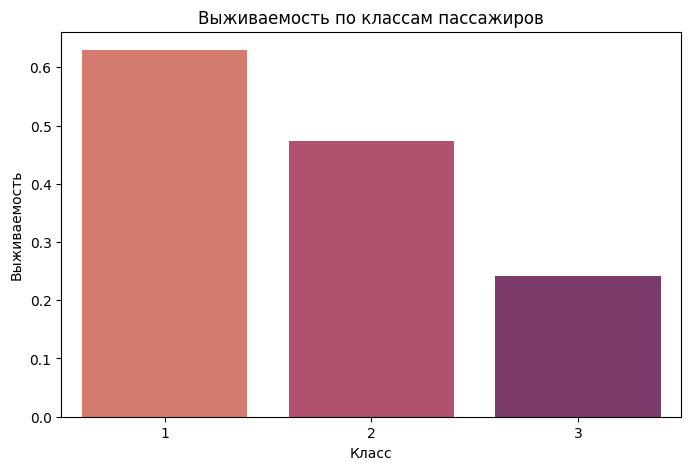

In [503]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x=df.groupby('Pclass')['Survived'].mean().index, 
    y=df.groupby('Pclass')['Survived'].mean().values, 
    palette="flare"
)

plt.title('Выживаемость по классам пассажиров')
plt.xlabel('Класс')
plt.ylabel('Выживаемость')
plt.xticks(rotation=0)
plt.show()


Из графика видно, что пассажиры первого класса имели намного больше шансов выжить по сравнению с пассажирами других классов, это можно связать с тем что класс пассажиров также зависил от их цены билета

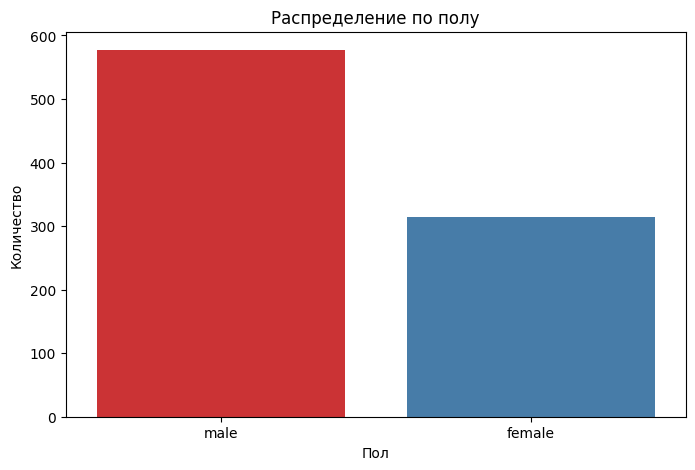

In [504]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=df['Sex'].value_counts().index, 
    y=df['Sex'].value_counts().values, 
    palette="Set1"
)
plt.title('Распределение по полу')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()


Исходя из этого графика видно, что на корабле было больше мужчин, чем женщин

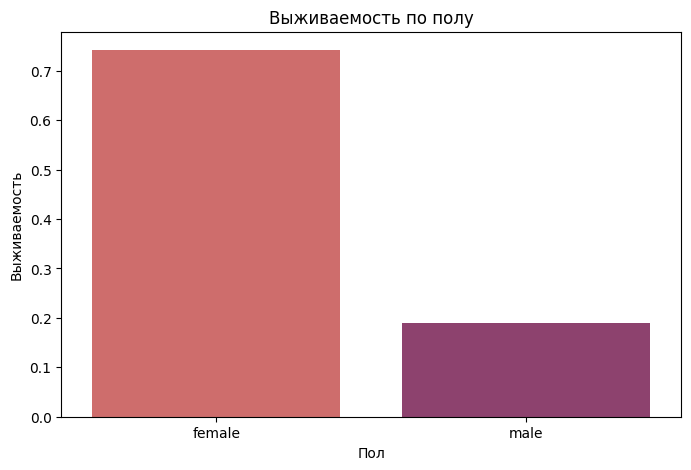

In [505]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x=df.groupby('Sex')['Survived'].mean().index,
    y=df.groupby('Sex')['Survived'].mean().values,
    palette="flare"
)

plt.title('Выживаемость по полу')
plt.xlabel('Пол')
plt.ylabel('Выживаемость')
plt.xticks(rotation=0)
plt.show()


Исходя из этого графика можно увидеть, что женщины имели шанс выжить в разы больше чем мужчины, также связывая этот график с предыдущим можно сказать, что количество не выживших мужчин больше количество выживших женщин, это связано с тем, что на корабле было больше мужчин чем женщин, а также с тем, что исторически женщин спасают первее, чем мужчин

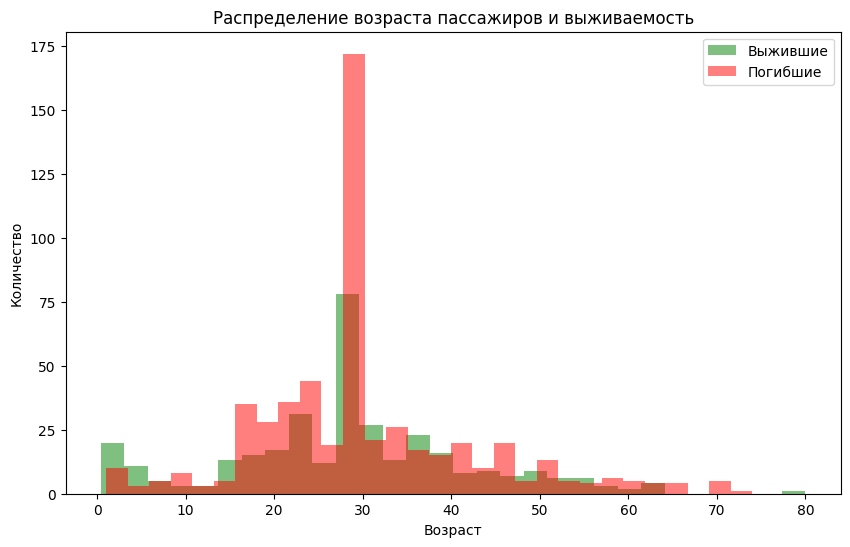

In [506]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['Survived'] == 1]['Age'], bins=30, alpha=0.5, label='Выжившие', color='green')
plt.hist(df[df['Survived'] == 0]['Age'], bins=30, alpha=0.5, label='Погибшие', color='red')
plt.title('Распределение возраста пассажиров и выживаемость')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend()
plt.show()


Исходя из этого графика можно увидеть, что люди с возрастом <15 имели больший шанс выжить чем умереть, обратную ситуацию можно увидеть с людьми других возрастов, которые имели больший шанс умереть, чем выжить.

В особенности выделяются люди с возрастом чуть меньше 30, которых было больше всего на корабле, и тем самым количество умерших с этим возрастом превышает все другие возраста

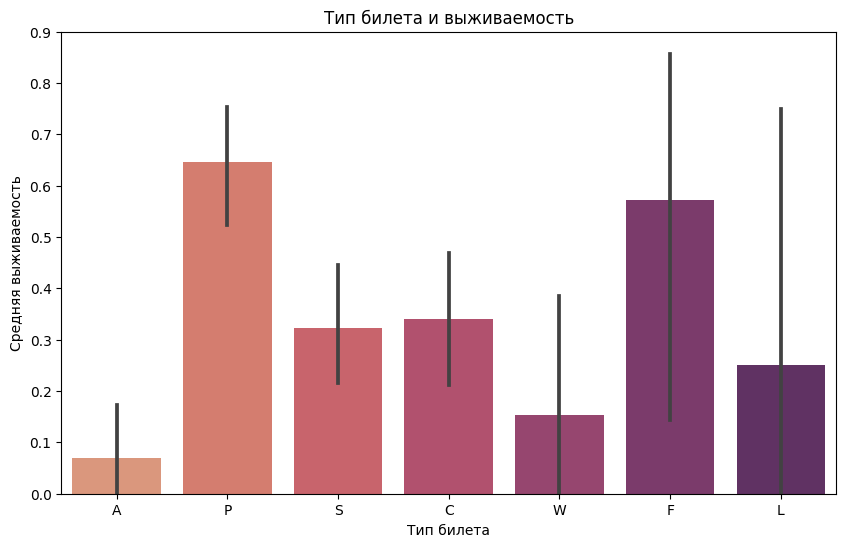

In [507]:
ticket_type= df['Ticket'].str.extract('([A-Za-z])', expand=False)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ticket_type, 
    y='Survived', 
    data=df, 
    palette="flare"
)
plt.title('Тип билета и выживаемость')
plt.xlabel('Тип билета')
plt.ylabel('Средняя выживаемость')
plt.show()

Из этого графика можно увидеть выживаемость людей на корабле от их типа билета, который был взят как буквенный индетификатор в билетах.

Так пассажиры с билетами типов [A, S, C, W, L] имели самые низки шансы выжить, когда пассажиры с билетами типов [P, F] имели гораздо большие шансы выжить по сравнению с обладателями других билетов

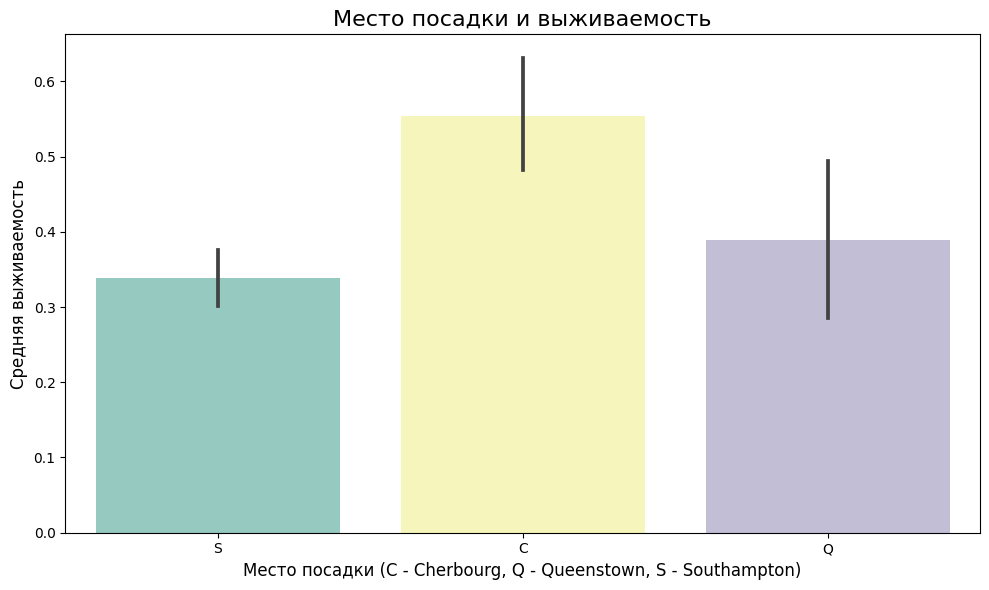

In [508]:
# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Embarked', 
    y='Survived', 
    data=df, 
    palette="Set3"
)
plt.title('Место посадки и выживаемость', fontsize=16)
plt.xlabel('Место посадки (C - Cherbourg, Q - Queenstown, S - Southampton)', fontsize=12)
plt.ylabel('Средняя выживаемость', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Из этого графика можно увидеть, что пассажиры на корабль садились из 3 разных портов: Chebourg, Queenstown, Southampton. Также стоит отметить, что пассажиры, которые сели на корабль в порту Chebourg имели самы высокие шансы выжить по сравнению с пассажирами из других портов

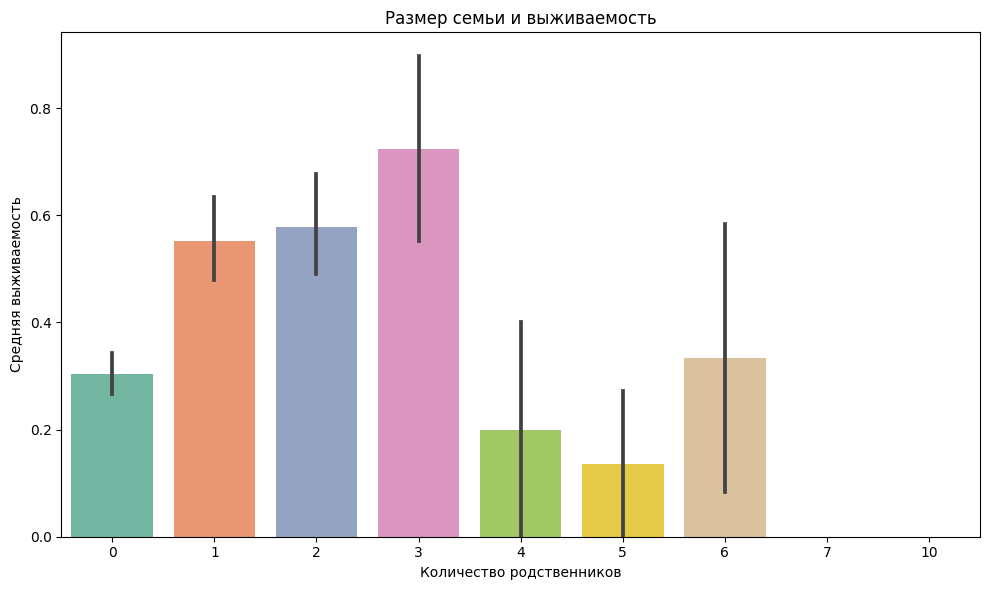

In [509]:
# Добавляем признак family_size
family_size = df['SibSp'] + df['Parch']

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x=family_size, 
    y='Survived', 
    data=df, 
    palette="Set2"
)
plt.title('Размер семьи и выживаемость')
plt.xlabel('Количество родственников')
plt.ylabel('Средняя выживаемость')
plt.tight_layout()
plt.show()


Исходя из этого графика видно, что люди имеющие разное количество родственников на корабле имели разные шансы выжить, так человек путешевствующиий в одиночку, а также те, у кого было больше 3 родственников на корабле имели шансы выжить <50%

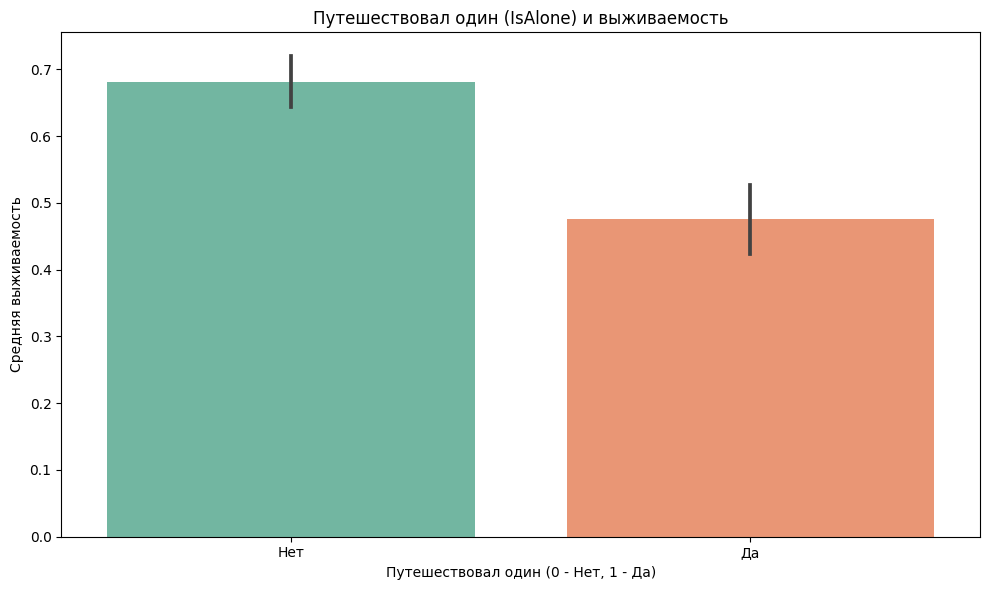

In [510]:
# Добавляем признак IsAlone
is_alone = (family_size == 0).astype('int')

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Survived', 
    y=is_alone, 
    data=df, 
    palette="Set2"
)
plt.title('Путешествовал один (IsAlone) и выживаемость')
plt.xlabel('Путешествовал один (0 - Нет, 1 - Да)')
plt.ylabel('Средняя выживаемость')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.tight_layout()
plt.show()


Продолжая тему предыдущего графика можно вынести такой признак как путешевствовал ли пассажир в одиночку. Например на этом графике как раз можно увидеть зависимость выживаемости от такого типа пассажиров, которая говорит нам о том, что одиночки выживали реже по сравнению с людьми, которые путешевствовали с родственниками

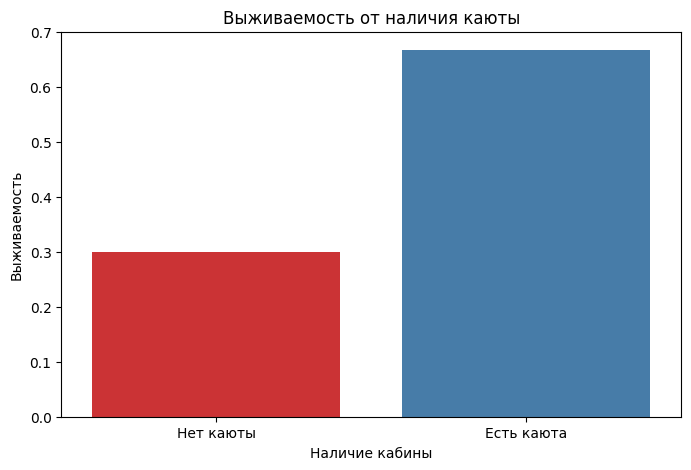

In [511]:
survival_by_cabin = df.groupby('Has_Cabin')['Survived'].mean().reset_index()

plt.figure(figsize=(8, 5))

sns.barplot(
    x='Has_Cabin', 
    y='Survived', 
    data=survival_by_cabin, 
    palette="Set1"
)

plt.xticks([0, 1], ['Нет каюты', 'Есть каюта'])

plt.title('Выживаемость от наличия каюты')
plt.ylabel('Выживаемость')
plt.xlabel('Наличие кабины')

plt.show()

Исходя из графика можно сделать вывод о том, что люди имеющие каюту, не важно какого класса выживали с в разы большей вероятностью по сравнению с людьми у которых не было каюты

## Создание новых признаков

In [512]:
# Категоризация Fare (разделим стоимость билета на группы)
df['Fare_Category'] = fare_category

# Создаем признак Family_Size
df['Family_Size'] = family_size

# Создаем признак Is_Alone
df['Is_Alone'] = is_alone

# Создаем признак Ticket_Type
df['Ticket_Type'] = ticket_type

In [513]:
# Извлекаем титулы из имени
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

# Приводим титулы к более общему виду
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Dona': 'Royalty'
}

df['Title'] = df['Title'].map(title_mapping).fillna('Rare')

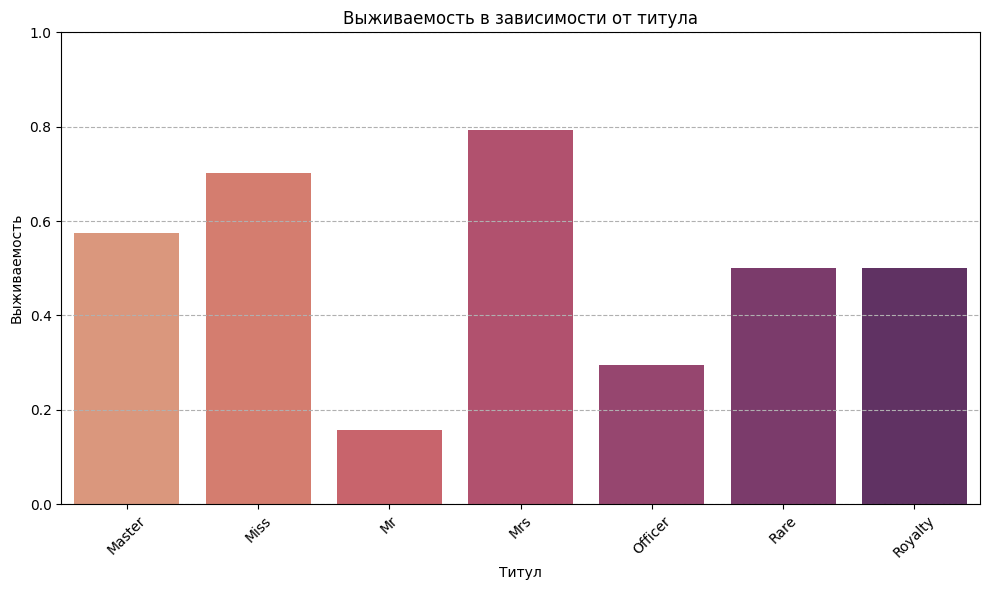

In [514]:
# Группировка данных и расчет средней выживаемости
survival_rates = df.groupby('Title')['Survived'].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Title', 
    y='Survived', 
    data=survival_rates, 
    palette="flare"
)
plt.title('Выживаемость в зависимости от титула')
plt.xlabel('Титул')
plt.ylabel('Выживаемость')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1)  # Установка предела для выживаемости (0-1)
plt.tight_layout()
plt.show()

На этом графике было представлено распределение выживаемости от различных групп титулов у пассажиров. Так люди с титулами Miss, Mrs имеют большие шансы выжить по сравнению с людьми с другими титулами. Обратная ситуация есть у людей с титулами Mr, Officer которые имели меньше всего шансов на выживание

Такое распределение может быть связано с частым присвоением титулов людям по половому признаку, вроде Miss, Mrs, Mr

In [515]:
# Выводим среднюю выживаемость для новых признаков
print(df[['Family_Size', 'Survived']].groupby('Family_Size').mean())
print(df[['Is_Alone', 'Survived']].groupby('Is_Alone').mean())
print(df[['Title', 'Survived']].groupby('Title').mean())
print(df[['Fare_Category', 'Survived']].groupby('Fare_Category').mean())
print(df[['Ticket_Type', 'Survived']].groupby('Ticket_Type').mean())

             Survived
Family_Size          
0            0.303538
1            0.552795
2            0.578431
3            0.724138
4            0.200000
5            0.136364
6            0.333333
7            0.000000
10           0.000000
          Survived
Is_Alone          
0         0.505650
1         0.303538
         Survived
Title            
Master   0.575000
Miss     0.702703
Mr       0.156673
Mrs      0.793651
Officer  0.294118
Rare     0.500000
Royalty  0.500000
               Survived
Fare_Category          
0              0.287253
1              0.421965
2              0.648148
3              0.735849
             Survived
Ticket_Type          
A            0.068966
C            0.340426
F            0.571429
L            0.250000
P            0.646154
S            0.323077
W            0.153846


/tmp/ipykernel_30/1161055035.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df[['Fare_Category', 'Survived']].groupby('Fare_Category').mean())


In [516]:
cat_columns = [] 
num_columns = [] 
for column_name in df.columns:
    if (df[column_name].dtypes == object): 
        cat_columns +=[column_name] 
    else:
        num_columns +=[column_name] 
    
print('Категориальные данные:\t',cat_columns, '\n Число столблцов ', len(cat_columns))
print('Числовые данные:\t', num_columns, '\n Число столблцов = ', len(num_columns))

Категориальные данные:	 ['Name', 'Sex', 'Ticket', 'Embarked', 'Ticket_Type', 'Title'] 
 Число столблцов  6
Числовые данные:	 ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'Fare_Category', 'Family_Size', 'Is_Alone'] 
 Число столблцов =  11


In [517]:
df = df.drop(columns=['Name', 'Ticket', 'PassengerId'])

## Создание корреляционной матрицы

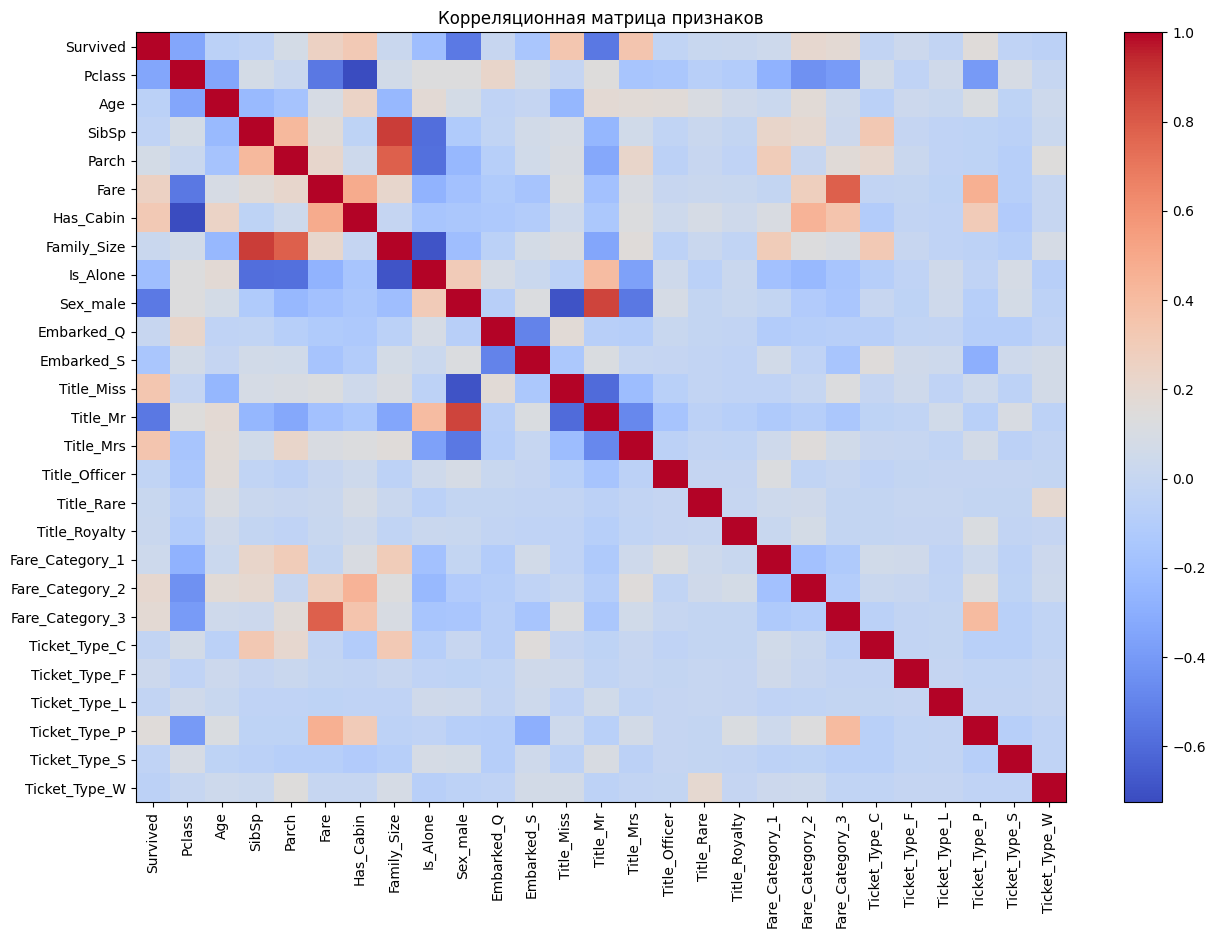

In [518]:
import numpy as np

# Закодирование категориальных данных
df_encoded = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title', 'Fare_Category', 'Ticket_Type'], drop_first=True)

# Создание корреляционной матрицы
corr_matrix = df_encoded.corr()

plt.figure(figsize=(15, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()

plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

plt.title('Корреляционная матрица признаков')
plt.show()

Из матрицы корреляции признаков видно, что набольшее положительное влияние на выживаемость имеют признаки Fare, Has_Cabin, Title_Miss, Title_Mrs, а наибольшее отрицательное влияние на выживаемость имеют такие признаки как Is_Alone, Title_Mr, Sex_Male

Остальные признаки не имеют достаточно явной корреляции с выживаемостью, что может говорить о том, что у таких признаков нет достаточной корреляции с целевым признаком, а имеют корреляцию между собой

## Создание и обучение модели

In [519]:
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели
model = keras.Sequential([
    layers.Dense(24, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.25)

# Оценка модели на тестовой выборке
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nТестовая точность: {accuracy:.2f}')

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3838 - loss: 0.7478 - val_accuracy: 0.3413 - val_loss: 0.7284
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3778 - loss: 0.7370 - val_accuracy: 0.3593 - val_loss: 0.7142
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3894 - loss: 0.7137 - val_accuracy: 0.3653 - val_loss: 0.7019
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4013 - loss: 0.7055 - val_accuracy: 0.4850 - val_loss: 0.6895
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4573 - loss: 0.6919 - val_accuracy: 0.5868 - val_loss: 0.6787
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5413 - loss: 0.6848 - val_accuracy: 0.7305 - val_loss: 0.6686
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6951 - loss: 0.6747 - val_accuracy: 0.7425 - val_loss: 0.6591
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6868 - loss: 0.6671 - val_accuracy: 0.7246 - val_loss: 0.6502
Ep

## Добавление кросс-валидации с использованием оболочки Keras для Scikit-Learn

In [520]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn):
        self.build_fn = build_fn
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=30, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

In [521]:
# Функция для создания модели
def create_model():
    model = keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [522]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Обертывание модели в KerasClassifierWrapper
keras_model = KerasClassifierWrapper(build_fn=create_model)

# Запуск кросс-валидации с выводом результатов для каждого фолда
print("\nЗапуск кросс-валидации...")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Переменная для хранения результатов всех фолдов
fold_results = []
all_y_true = []  # Список для реальных меток всех фолдов
all_y_pred = []  # Список для предсказанных меток всех фолдов

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"\nФолд {fold}...")
    
    # Разделяем данные на обучающую и тестовую выборки для этого фолда
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Используем iloc для строк
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Аналогично для y
    
    # Обучаем модель
    keras_model.fit(X_train, y_train)
    
    # Предсказываем для тестового набора
    y_pred = keras_model.predict(X_test)
    
    # Оценка точности для текущего фолда
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for fold {fold}: {accuracy:.4f}")
    
    # Добавляем результаты для этого фолда в общий список
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    # Печатаем классификационный отчет для текущего фолда
    print(f"Classification Report for fold {fold}:\n")
    print(classification_report(y_test, y_pred))
    
    # Сохраняем результаты для этого фолда
    fold_results.append((fold, accuracy))

# Выводим результаты по всем фолдам
print("\nРезультаты кросс-валидации для всех фолдов:")
for fold, accuracy in fold_results:
    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Печатаем общий классификационный отчет по всем фолдам
print("\nОбщий Classification Report по всем фолдам:\n")
print(classification_report(all_y_true, all_y_pred))



Запуск кросс-валидации...

Фолд 1...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for fold 1: 0.6927
Classification Report for fold 1:

              precision    recall  f1-score   support

           0       0.70      0.86      0.78       110
           1       0.66      0.42      0.51        69

    accuracy                           0.69       179
   macro avg       0.68      0.64      0.64       179
weighted avg       0.69      0.69      0.67       179


Фолд 2...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for fold 2: 0.7079
Classification Report for fold 2:

              precision    recall  f1-score   support

           0       0.71      0.88      0.79       110
           1       0.69      0.43      0.53        68

    accuracy                           0.71       178
   macro avg       0.70      0.65      0.66       178
weighted avg       0.70      0.71      0.69       178


Фолд 3...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for fold 3: 0.7247
Classification Report for fold 3:

              precision    recall  f1-score   support

           0       0.72      0.92      0.80       110
           1       0.76      0.41      0.53        68

    accuracy                           0.72       178
   macro avg       0.74      0.66      0.67       178
weighted avg       0.73      0.72      0.70       178


Фолд 4...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for fold 4: 0.7584
Classification Report for fold 4:

              precision    recall  f1-score   support

           0       0.74      0.93      0.83       110
           1       0.80      0.49      0.61        68

    accuracy                           0.76       178
   macro avg       0.77      0.71      0.72       178
weighted avg       0.77      0.76      0.74       178


Фолд 5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for fold 5: 0.6461
Classification Report for fold 5:

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       109
           1       0.56      0.41      0.47        69

    accuracy                           0.65       178
   macro avg       0.62      0.60      0.60       178
weighted avg       0.63      0.65      0.63       178


Результаты кросс-валидации для всех фолдов:
Fold 1: Accuracy = 0.6927
Fold 2: Accuracy = 0.7079
Fold 3: Accuracy = 0.7247
Fold 4: Accuracy = 0.7584
Fold 5: Accuracy = 0.6461

Общий Classification Report по всем фолдам:

              precision    recall  f1-score   support

           0       0.71      0.88      0.79       549
           1       0.69      0.43      0.53       342

    accuracy                           0.71       891
   macro avg       0.70      0.65      0.66       891
weighted avg       0.70      0.71      0.69       891



In [523]:
tn, fp, fn, tp = conf_matrix.ravel()

print(f"True Negative (TN): Модель предсказала, что человек выживет, и он действительно выжил: {tn}")
print(f"False Positive (FP): Модель предсказала, что человек погибнет, но он выжил: {fp}")
print(f"False Negative (FN): Модель предсказала, что человек выживет, но он погиб: {fn}")
print(f"True Positive (TP): Модель предсказала, что человек погибнет, и он действительно погиб: {tp}")

True Negative (TN): Модель предсказала, что человек выживет, и он действительно выжил: 495
False Positive (FP): Модель предсказала, что человек погибнет, но он выжил: 54
False Negative (FN): Модель предсказала, что человек выживет, но он погиб: 195
True Positive (TP): Модель предсказала, что человек погибнет, и он действительно погиб: 147


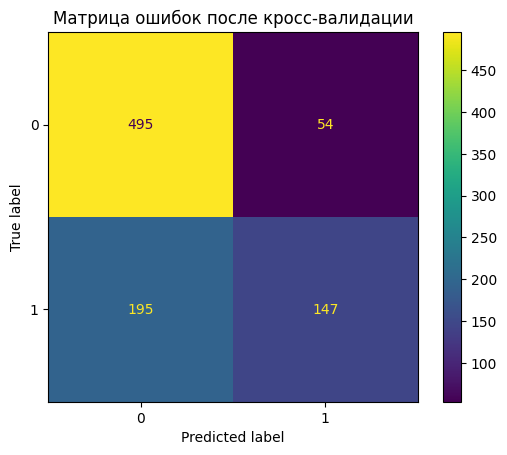

In [524]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y, (y_pred_cv > 0.5).astype(int))
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Матрица ошибок после кросс-валидации')
plt.show()

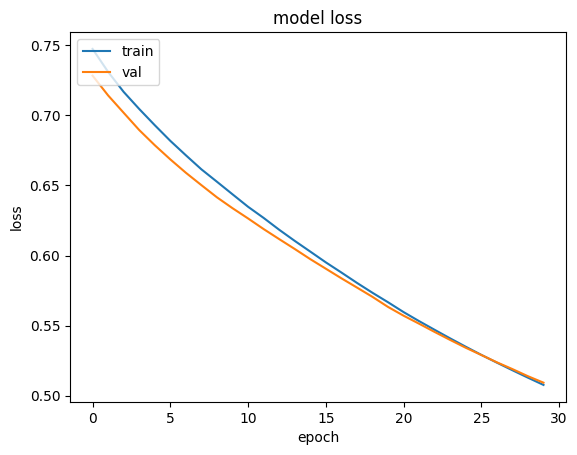

In [525]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

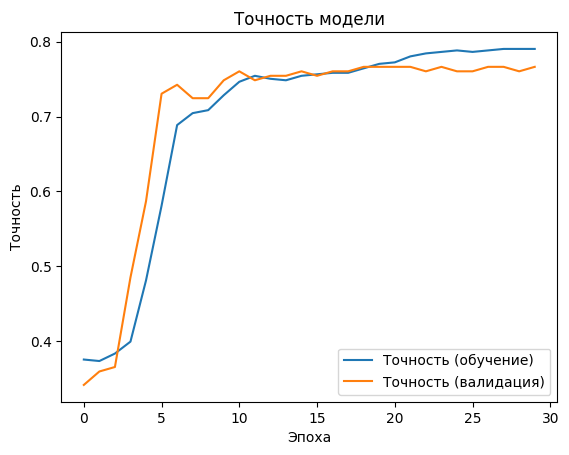

In [526]:
plt.plot(history.history['accuracy'], label='Точность (обучение)')
plt.plot(history.history['val_accuracy'], label='Точность (валидация)')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()


Модель в кроссвалидации показала довольно хорошую стабильность, что подтверждает ее надежность, модель имеет довольно хорошую тестовую точность для этой задачи ~80%, при этом модель является довольно простой и имеет небольшое количество нейронов. Также исходя из графиков можно сказать, что модель также не переобучилась на этих данных.

Еще больше увеличить точность (сделать точность >85%) для этой задачи будет очень нелегко т.к. изначально присутствуют данные с большим количеством пропущенных значений